"""

    GGPD: Deep Deterministic Policy Gradient [1] implementation in PyTorch [2].
    Minor changes were made to the backpropagation of the error for the critic and actor. 
    Also another type of noise was used in new task conditions.
    
    References
    ----------
    
    [1]   
    Lillicrap, T., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., Silver, D. & Wierstra, D. (2015). 
    Continuous control with deep reinforcement learning. International Conference on Learning Representations, 
    abs/1509.02971. https://arxiv.org/abs/1509.02971

    [2] https://github.com/ghliu/pytorch-ddpg
"""

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from ddpg_fol.ddpg import DDPG
from ddpg_fol.util import *
from ddpg_fol.evaluator import Evaluator

from environment import Environment

# NN

In [4]:
train_size = 100
test_size = 20
np.random.seed(1)

def generate_training_data(num_samples):
    X_train = np.linspace(-1, 1, num_samples).reshape(-1, 1)
    y_train = np.random.random(num_samples) * 0.9 + 0.1
    return X_train, y_train

num_models = train_size  + test_size  
num_samples = 6  

gp_models = []
prediction_functions = []
envs = []
observes = []

for _ in range(num_models):
    X_train, y_train = generate_training_data(num_samples)
    
    kernel = RBF(length_scale=3)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
    gp.fit(X_train, y_train)
    
    gp_models.append(gp)
    
    def prediction_function(x, model=gp):
        x = np.array(x).reshape(-1, 1) 
        y_pred, _ = model.predict(x, return_std=True)
        if(y_pred.flatten().shape[0] == 1):
            return y_pred.flatten()[0]
        return y_pred.flatten()  
    
    prediction_functions.append(prediction_function)

    l_bounds = [-1,]
    u_bounds = [1,]
    env = Environment(X = np.array([[0]]*20),y = prediction_function(np.array([[0]]*20)),l_bounds = l_bounds,\
                      u_bounds = u_bounds, func = prediction_function, model = 'NN',\
                      model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},\
                      state_mode='predictions+last_points',N=20)
    observes.append(env.reset())
    envs.append(env)

In [6]:
class Arg:
    def __init__(self,):
        self.mode = 'train'
        self.hidden1 = 16
        self.hidden2 = 16
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=30
        self.validate_steps=500
        self.output='output_NN+'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=4000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = envs[0].observation_space.shape[0]
nb_actions = envs[0].action_space.shape[0]

evaluate = Evaluator(test_size, args.validate_steps, args.output, max_episode_length=args.max_episode_length)
agent = DDPG(nb_states, nb_actions, args)
agent.epsilon = 0.5

train_functions_gauss = prediction_functions[:train_size]
test_functions_gauss = prediction_functions[train_size:]

train_envs = envs[:train_size]
test_envs = envs[train_size:]

  0%|                                                                                    | 0/100 [00:00<?, ?it/s]/Users/annaermakova/Desktop/rl/models/NN.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32)
100%|███████████████████████████████████████████████████████████▉| 99.99999999999005/100 [54:07<00:00, 32.48s/it]


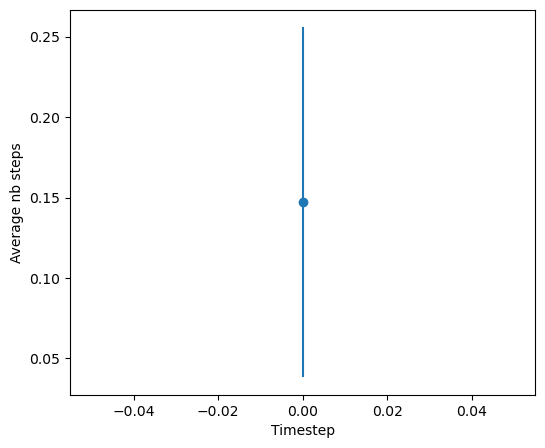

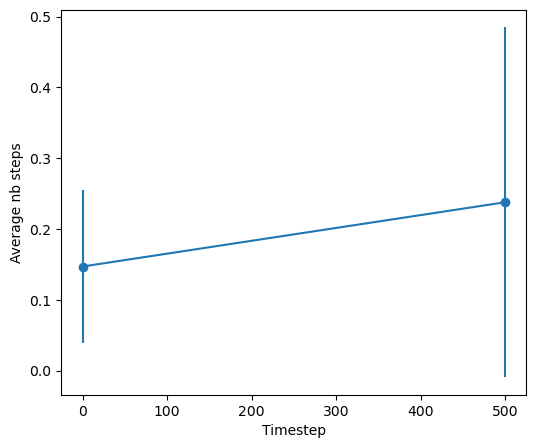

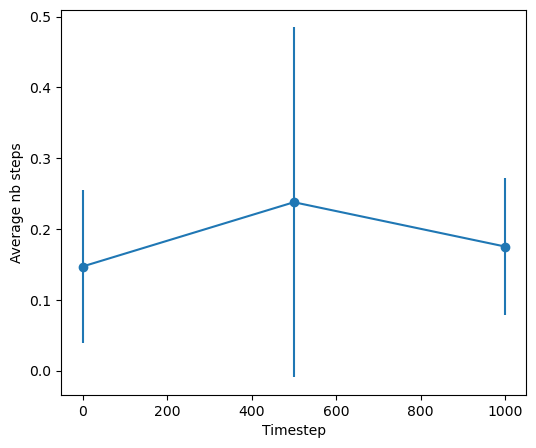

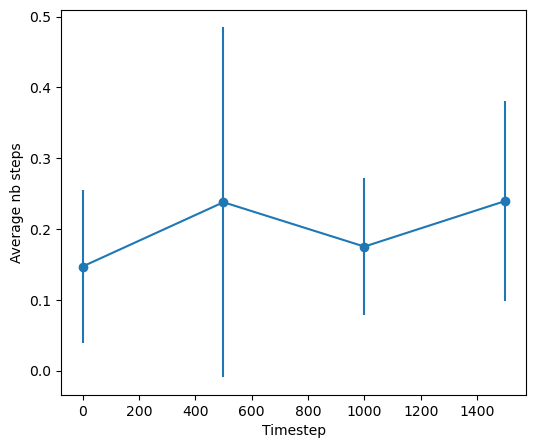

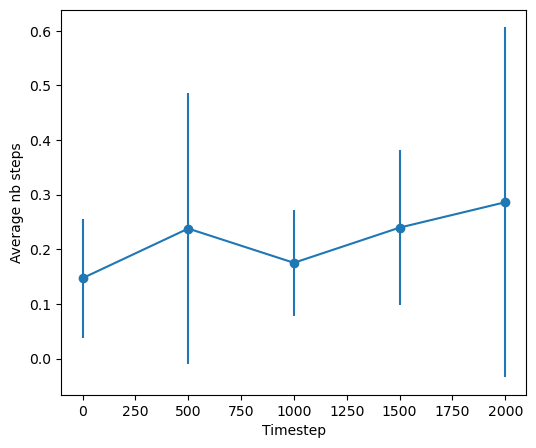

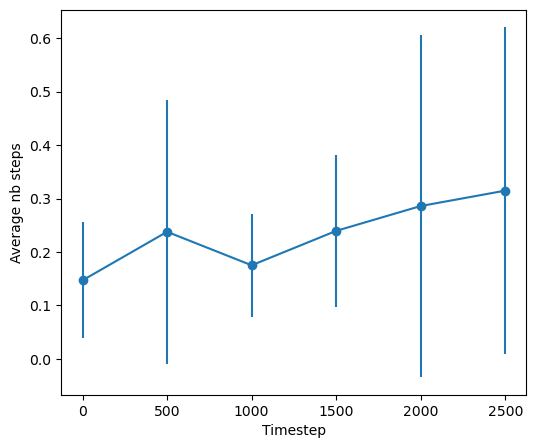

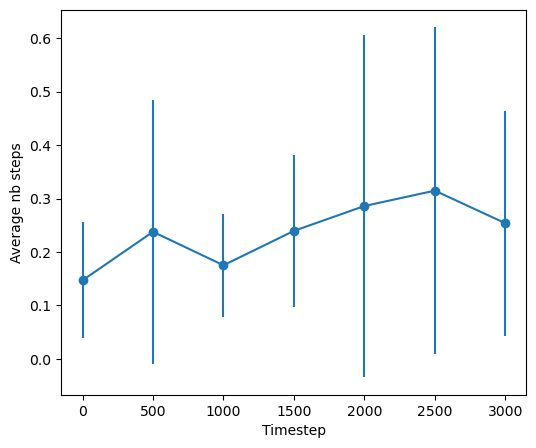

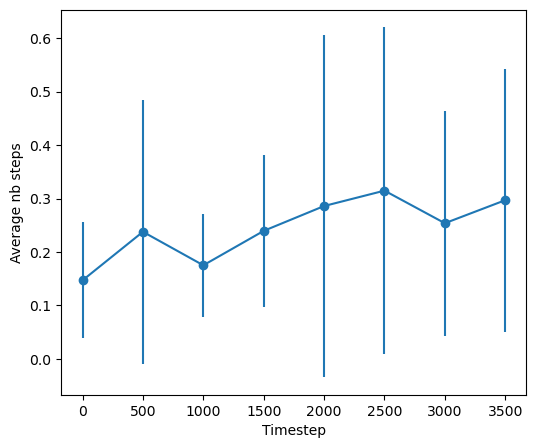

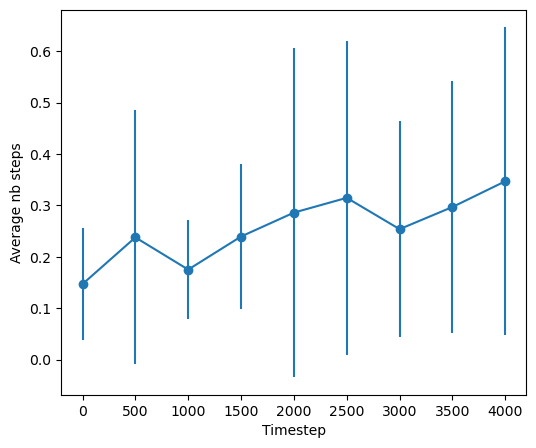

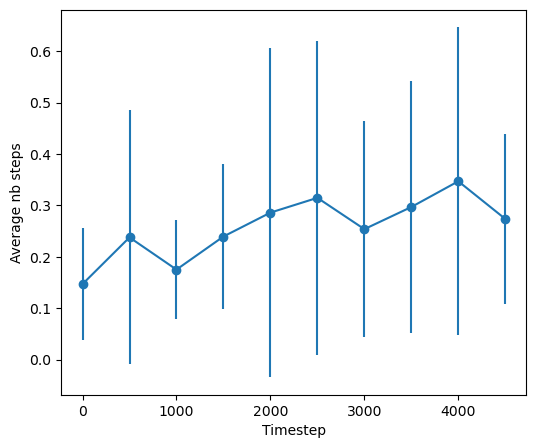

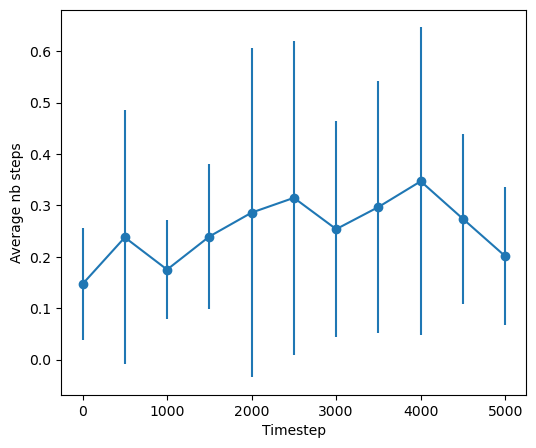

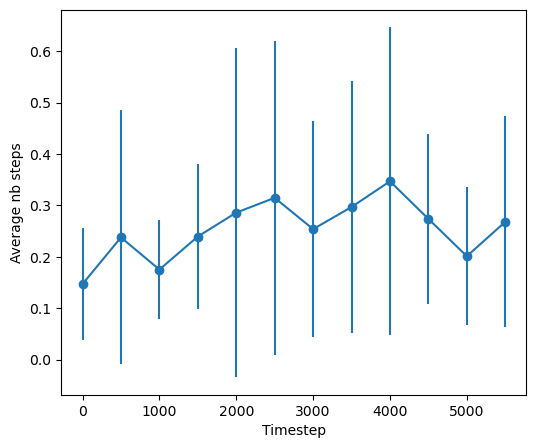

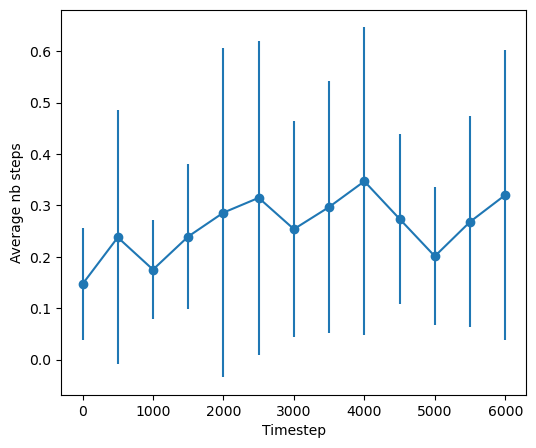

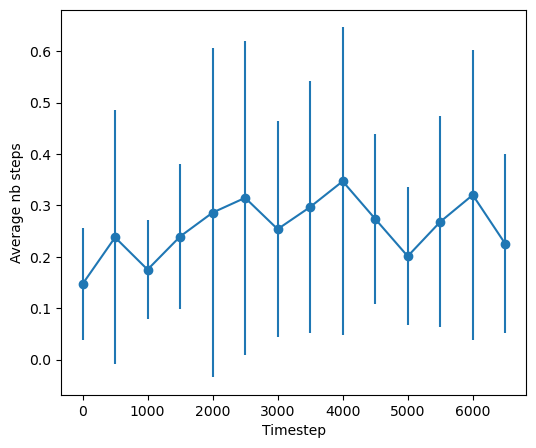

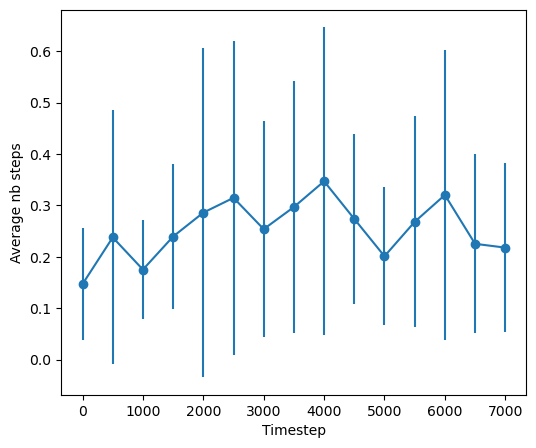

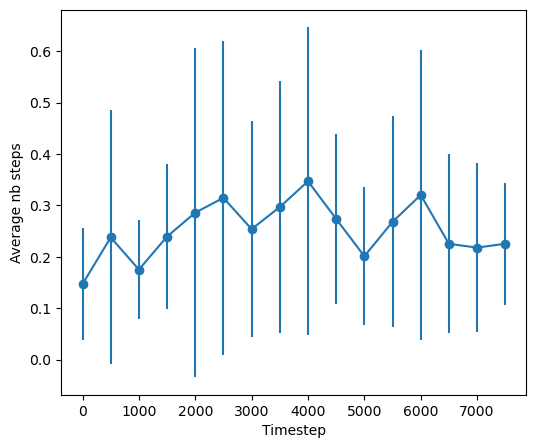

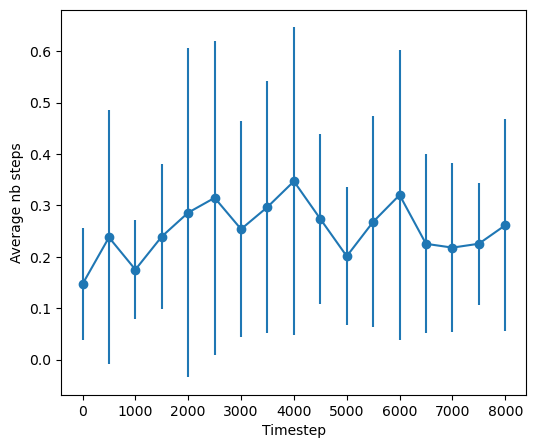

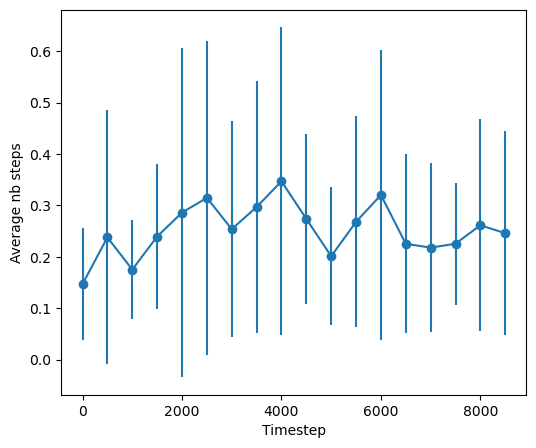

In [7]:
res = []

num_steps =  np.zeros(train_size)
agent.is_training = True
episode = episode_steps = 0
num_iterations = 9000
total_steps = 0
i=0
with tqdm(total=100) as pbar:
    while total_steps < num_iterations: 
        idx = i#random.sample(range(train_size), 1)[0]
        env = train_envs[idx]
        obs = observes[idx]
        num_step = num_steps[idx]

        if total_steps <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(obs)
            
        observation_new, reward, done, info = env.step(action)
        observes[idx] = deepcopy(observation_new)

        if reward<1:
            agent.observe(obs, action, reward, done)

        if episode > 5 and num_step % 10 == 0: 
            agent.update_policy()

        if total_steps>0 and total_steps % 500 == 0: 
            for _ in range(1000):
                agent.update_policy()
                
        if args.validate_steps > 0 and total_steps % args.validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(test_envs, policy, debug=False, visualize=False)
            #if debug: prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        num_steps[idx] = num_step + 1
        total_steps += 1
        pbar.update(100/num_iterations)
        if done or (num_steps[idx]>60): 
            res.append(reward)
            agent.save_model(args.output)
            #env.toy_Plot(np.linspace(-1,1,50))

            observes[idx] = deepcopy(env.reset())
            num_steps[idx] =0
            episode += 1
            i=(i+1)%train_size

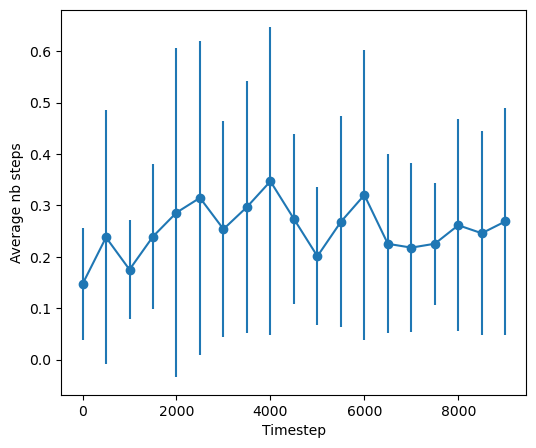

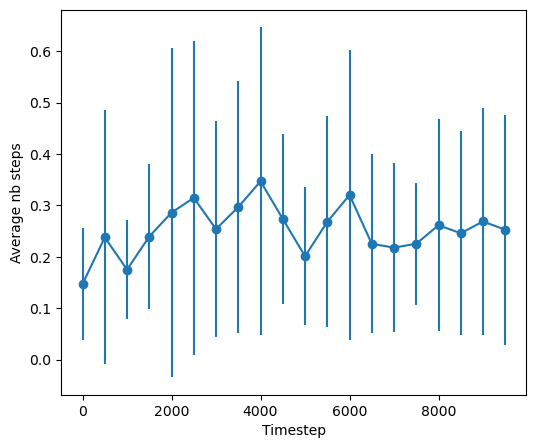

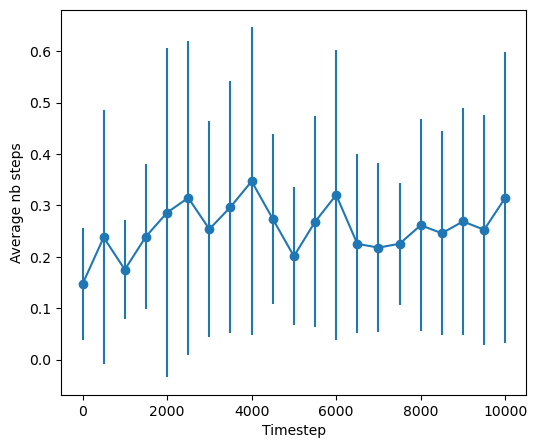

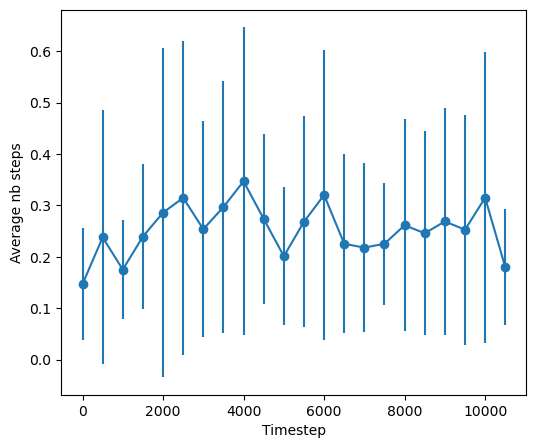

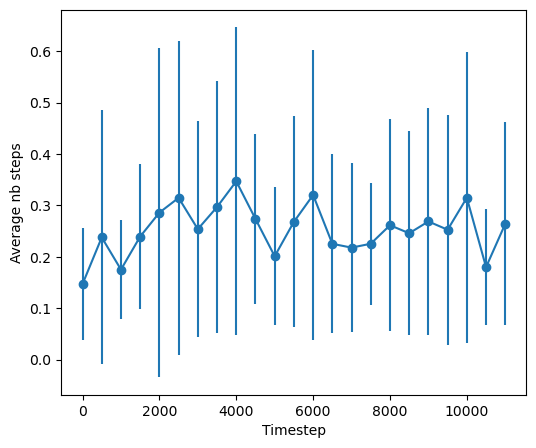

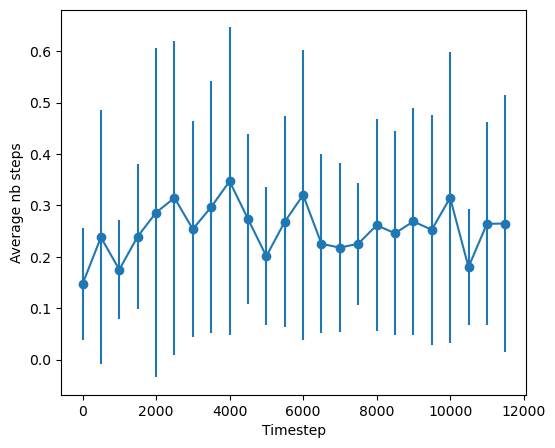

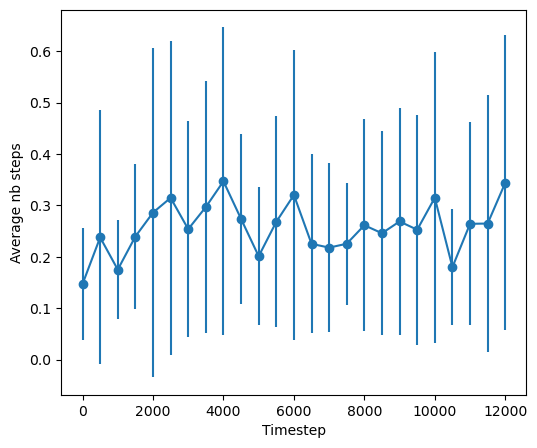

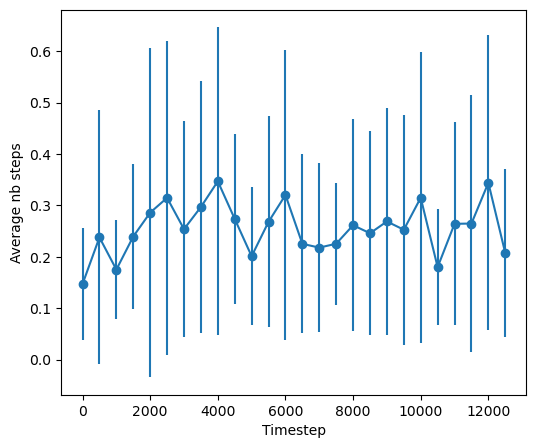

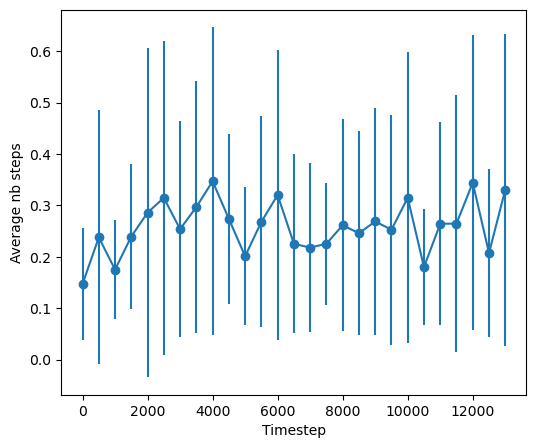

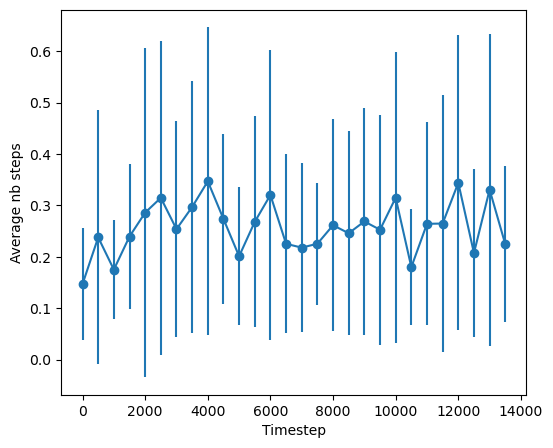

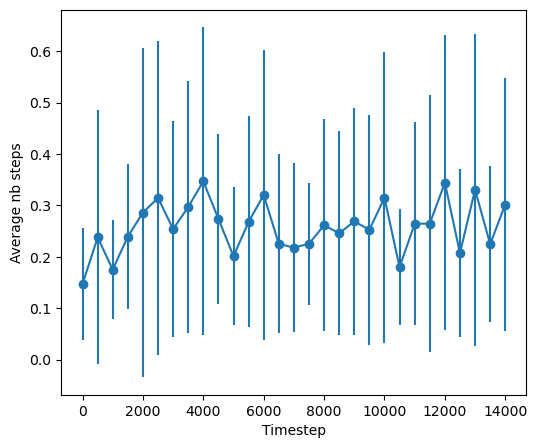

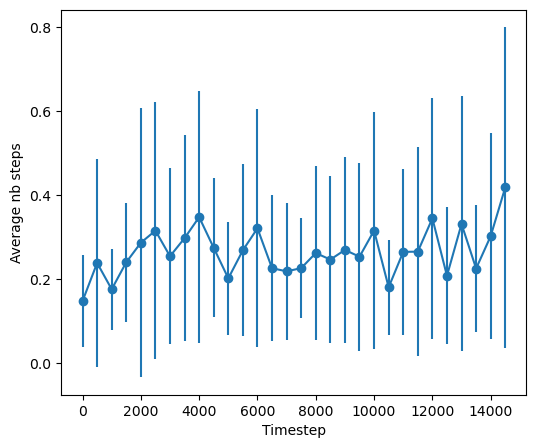

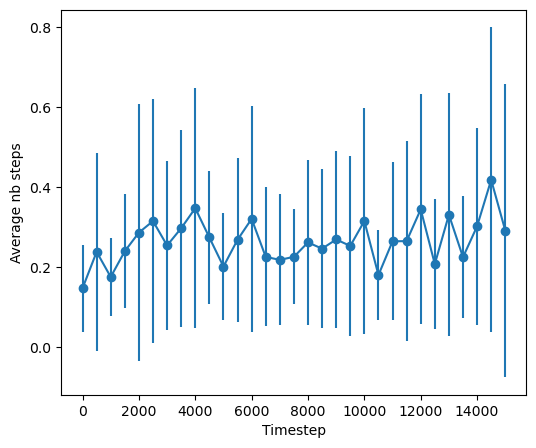

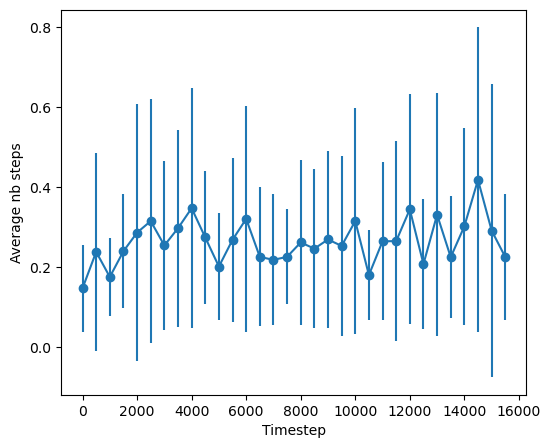

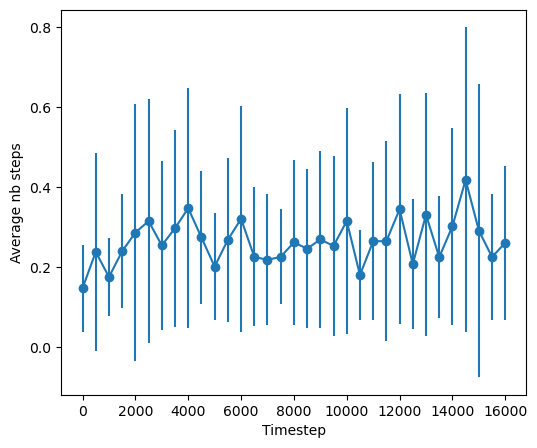

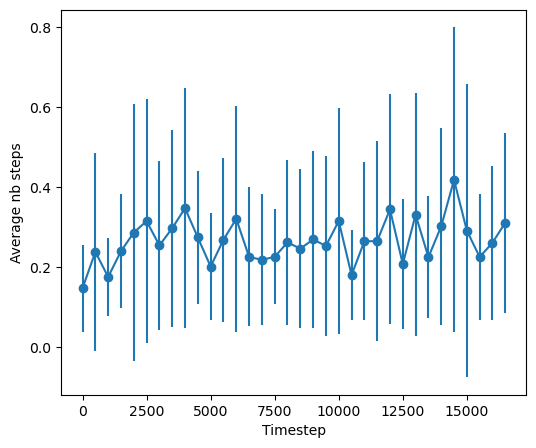

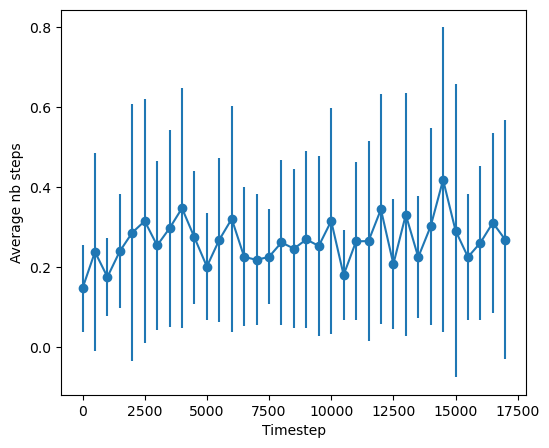

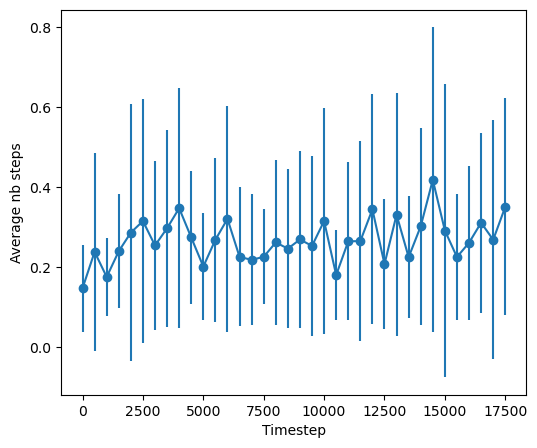

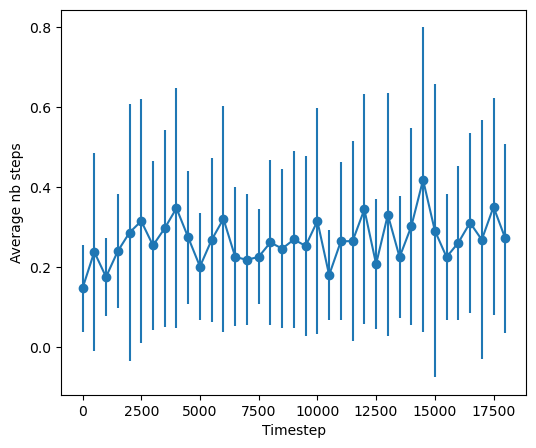

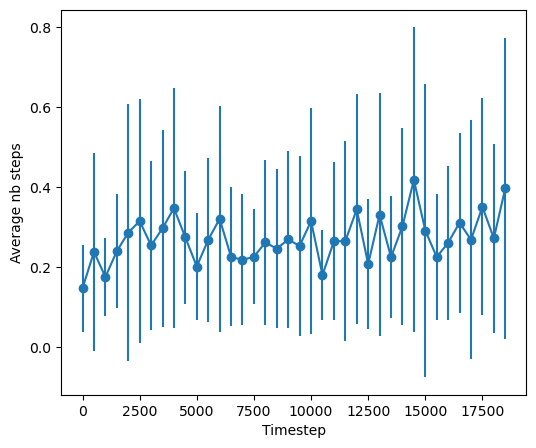

In [11]:
while total_steps < num_iterations+10000: 
        idx = i#random.sample(range(train_size), 1)[0]
        env = train_envs[idx]
        obs = observes[idx]
        num_step = num_steps[idx]

        if total_steps <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(obs)
            
        observation_new, reward, done, info = env.step(action)
        observes[idx] = deepcopy(observation_new)

        if reward<1:
            agent.observe(obs, action, reward, done)

        if episode > 5 and num_step % 10 == 0: 
            agent.update_policy()

        if total_steps>0 and total_steps % 500 == 0: 
            for _ in range(1000):
                agent.update_policy()
                
        if args.validate_steps > 0 and total_steps % args.validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(test_envs, policy, debug=False, visualize=False)
            #if debug: prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        num_steps[idx] = num_step + 1
        total_steps += 1
        pbar.update(100/num_iterations)
        if done or (num_steps[idx]>60): 
            res.append(reward)
            agent.save_model(args.output)
            #env.toy_Plot(np.linspace(-1,1,50))

            observes[idx] = deepcopy(env.reset())
            num_steps[idx] =0
            episode += 1
            i=(i+1)%train_size

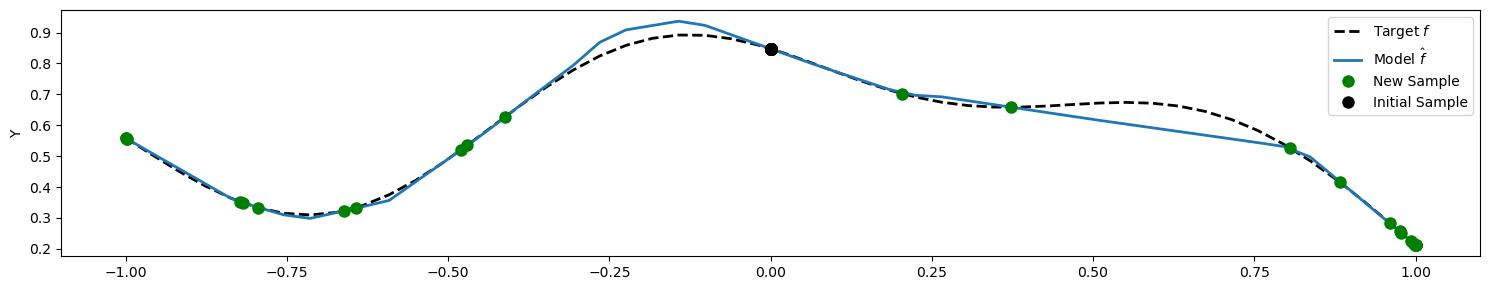

In [15]:
env = envs[8]
state = env.reset()
agent.is_training = False

done=False
while not done:
    action = agent.select_action(state)
    state, reward, done, info = env.step(action)
env.toy_Plot(np.linspace(-1,1,50))

# GP

In [23]:
train_size = 200
test_size = 10
np.random.seed(1)

def generate_training_data(num_samples):
    X_train = np.linspace(-1, 1, num_samples).reshape(-1, 1)
    y_train = np.random.random(num_samples) * 0.9 + 0.1
    return X_train, y_train

num_models = train_size  + test_size  
num_samples = 6  

gp_models = []
prediction_functions = []
envs = []
observes = []

for _ in range(num_models):
    X_train, y_train = generate_training_data(num_samples)
    
    kernel = RBF(length_scale=3)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
    gp.fit(X_train, y_train)
    
    gp_models.append(gp)
    
    def prediction_function(x, model=gp):
        x = np.array(x).reshape(-1, 1) 
        y_pred, _ = model.predict(x, return_std=True)
        if(y_pred.flatten().shape[0] == 1):
            return y_pred.flatten()[0]
        return y_pred.flatten()  
    
    prediction_functions.append(prediction_function)

    l_bounds = [-1,]
    u_bounds = [1,]
    Environment(X = np.array([[0]]*20),y = prediction_function(np.array([[0]]*20)),l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = prediction_function, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * RBF(length_scale=3),'n_restarts_optimizer':100},state_mode='predictions+last_points',N=20)
   
    observes.append(env.reset())
    envs.append(env)

In [24]:
class Arg:
    def __init__(self,):
        self.mode = 'train'
        self.hidden1 = 32
        self.hidden2 = 32
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=30
        self.validate_steps=500
        self.output='output_GP+'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=10000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = envs[0].observation_space.shape[0]
nb_actions = envs[0].action_space.shape[0]

evaluate = Evaluator(test_size, args.validate_steps, args.output, max_episode_length=args.max_episode_length)
agent = DDPG(nb_states, nb_actions, args)
agent.epsilon = 0.5

train_functions_gauss = prediction_functions[:train_size]
test_functions_gauss = prediction_functions[train_size:]

train_envs = envs[:train_size]
test_envs = envs[train_size:]

 67%|████████████████████████████████████████                    | 66.66666666667099/100 [42:06<21:58, 39.57s/it]/Users/annaermakova/Desktop/rl/ddpg_fol/evaluator.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(6, 5))
100%|█████████████████████████████████████████████████████████▉| 99.99999999997401/100 [1:11:56<00:00, 43.17s/it]


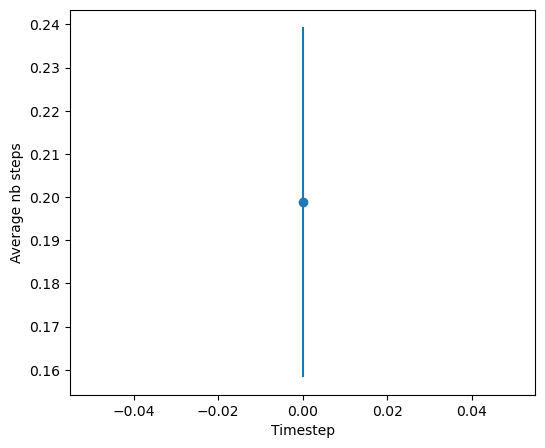

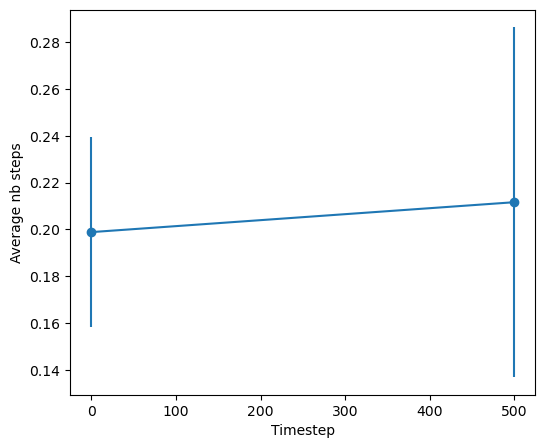

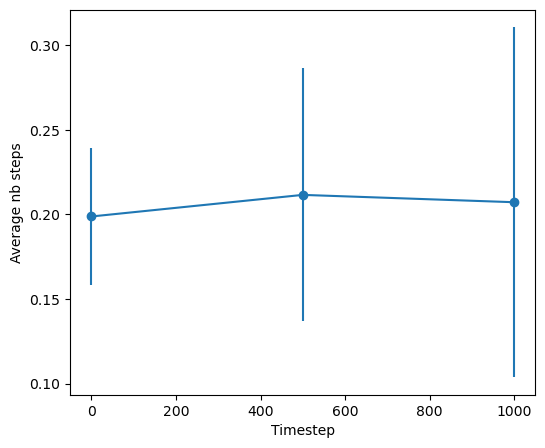

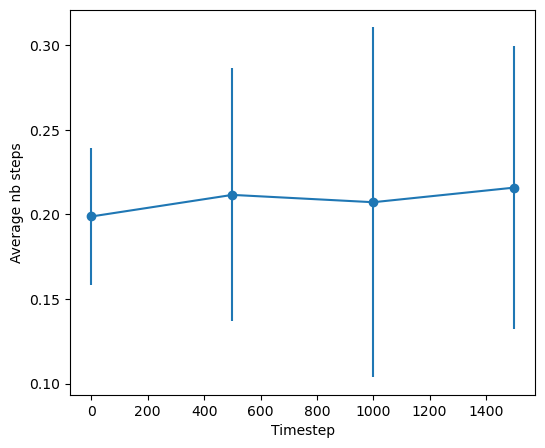

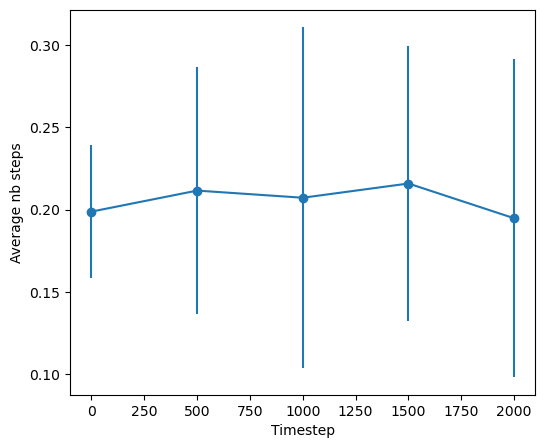

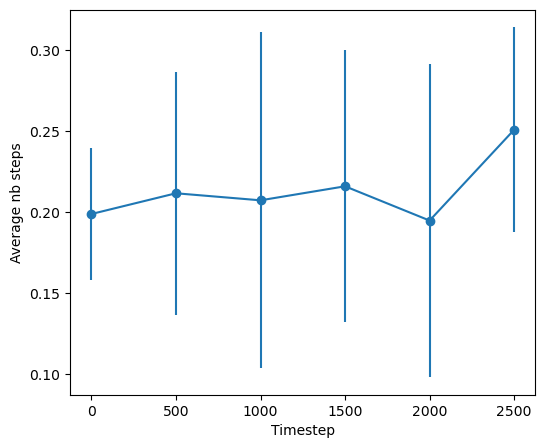

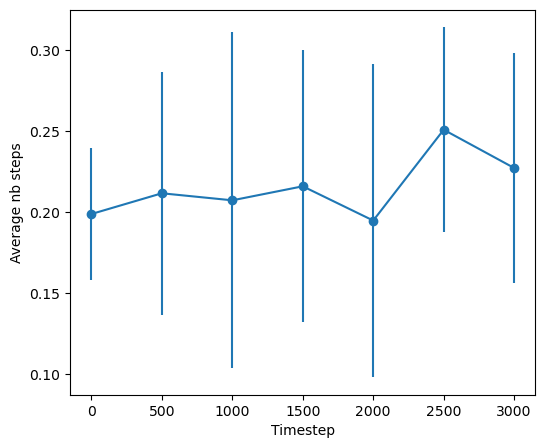

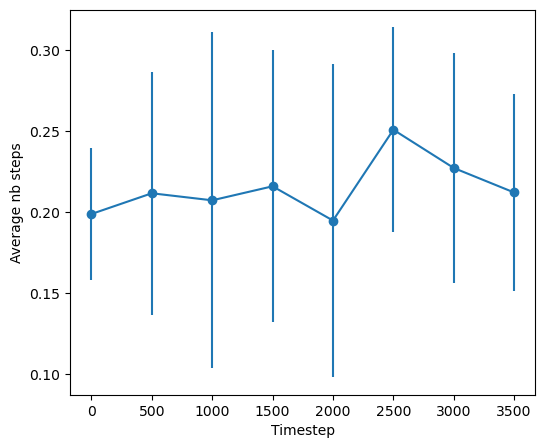

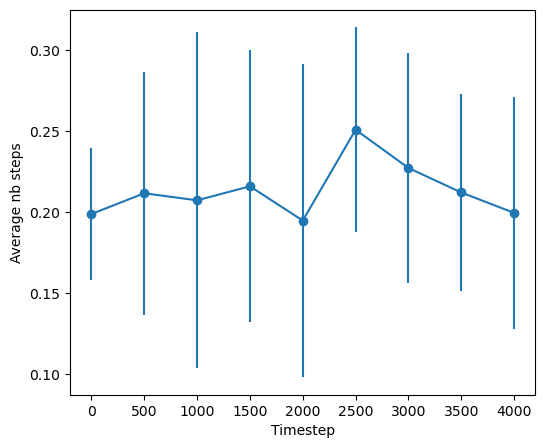

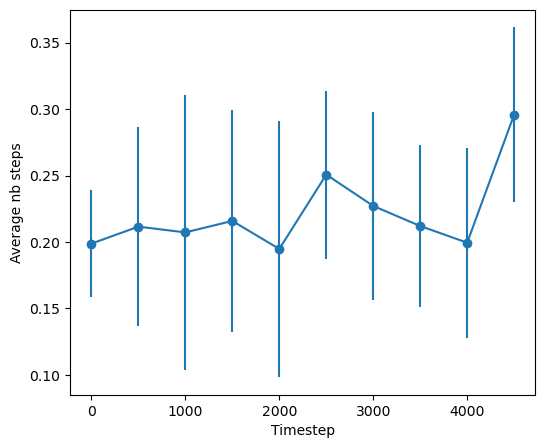

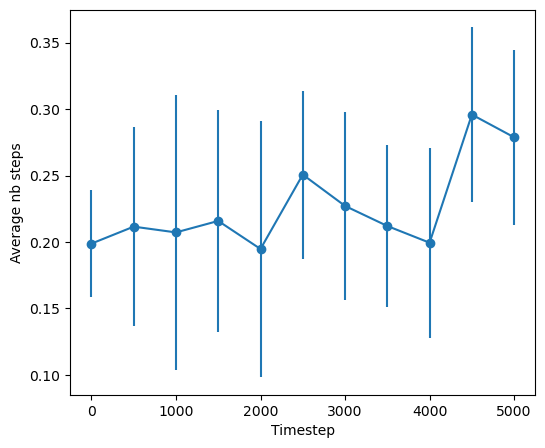

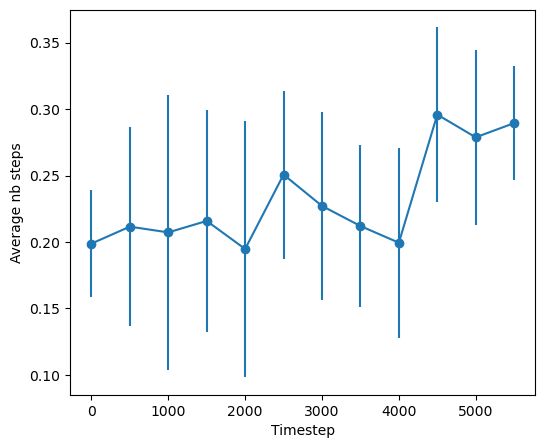

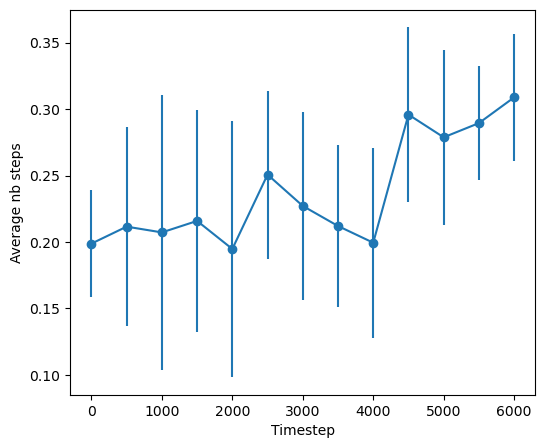

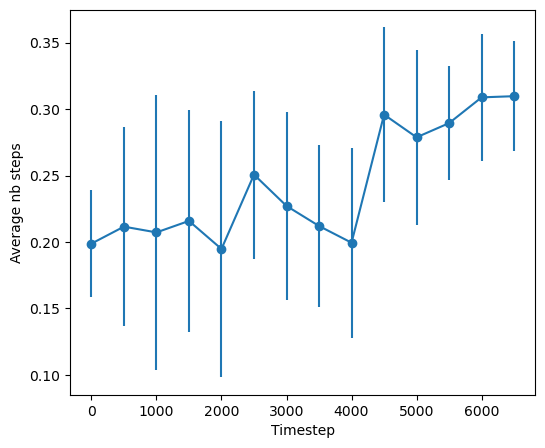

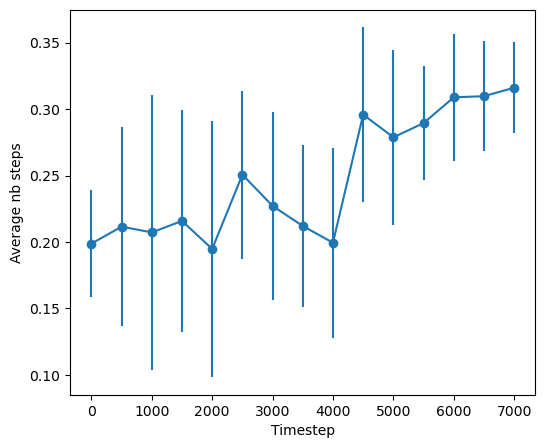

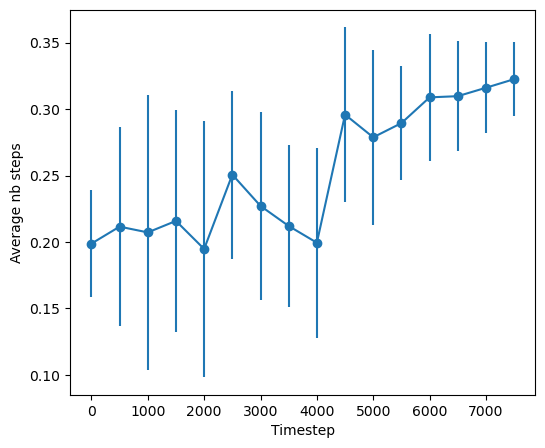

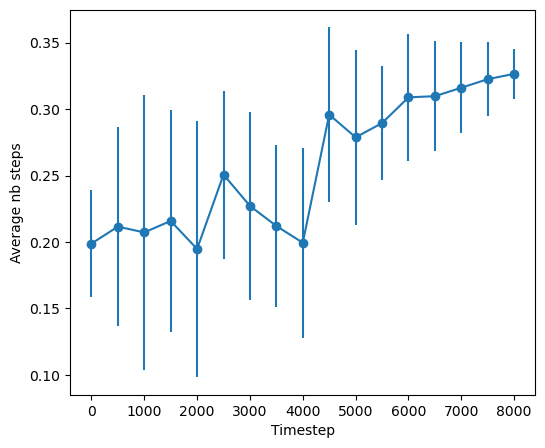

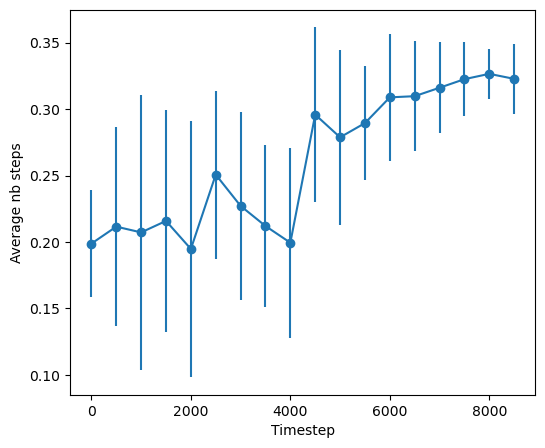

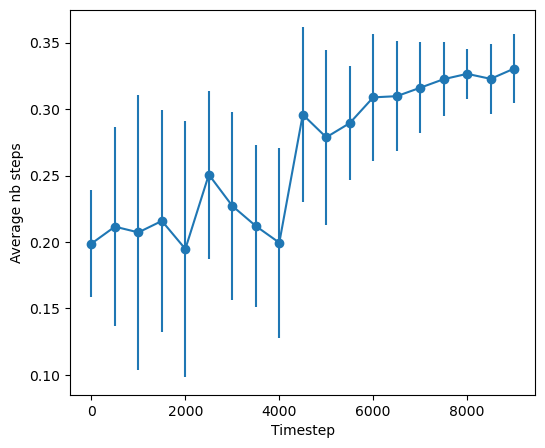

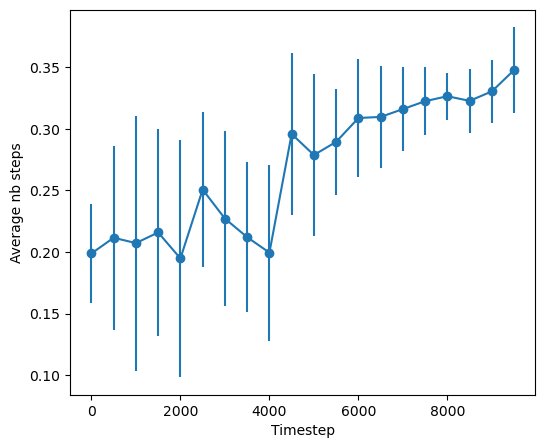

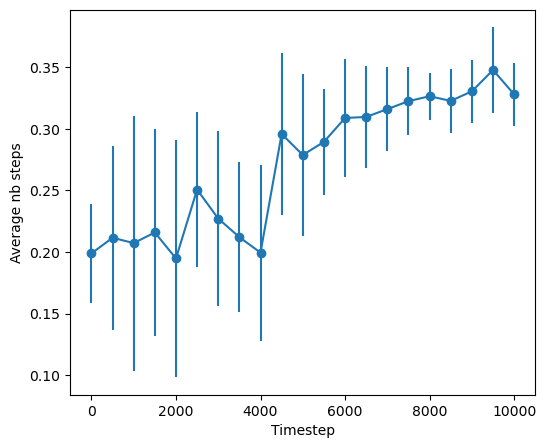

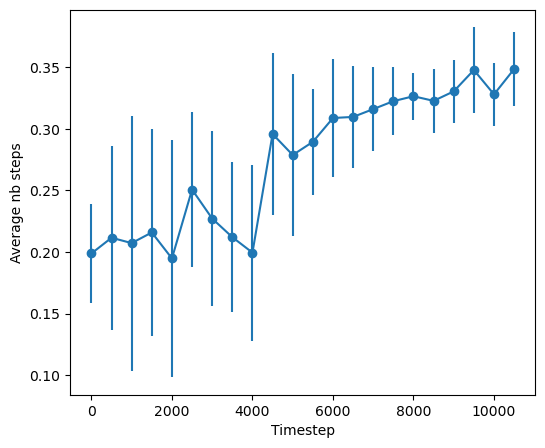

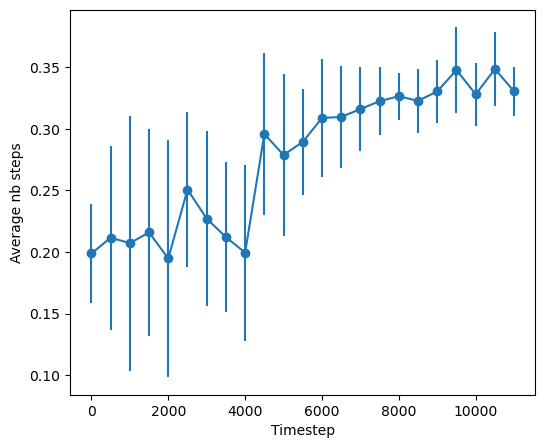

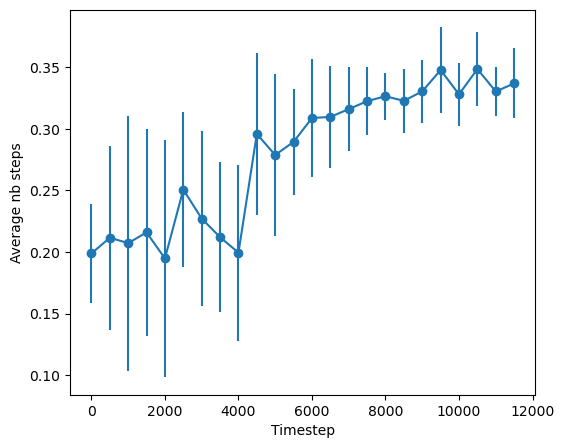

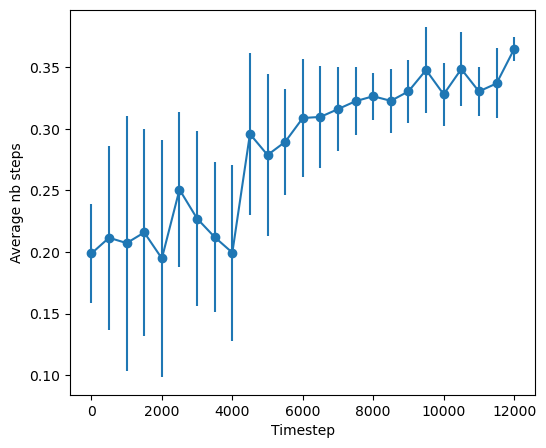

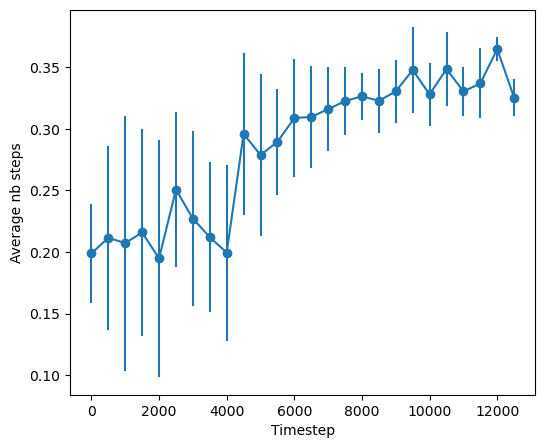

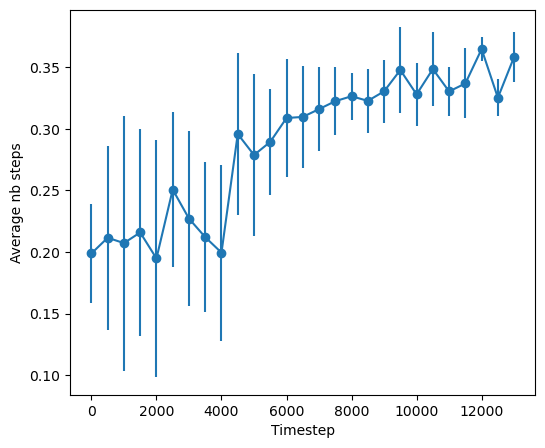

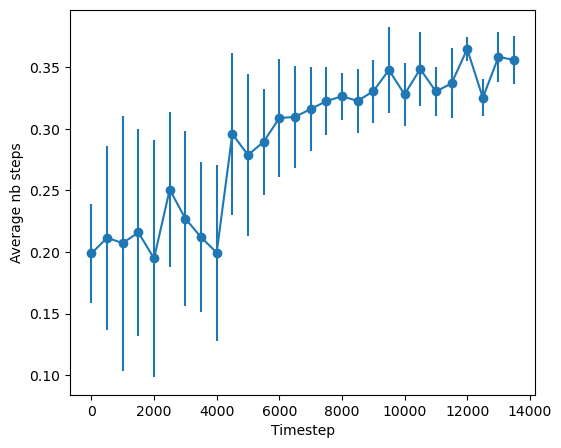

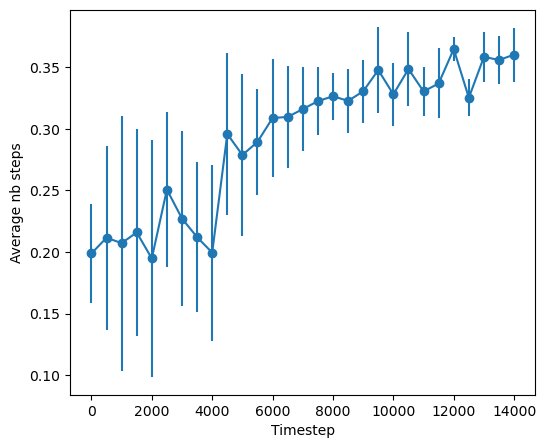

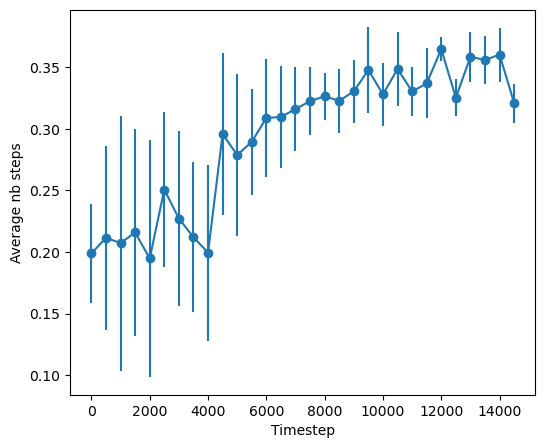

In [25]:
res = []

num_steps =  np.zeros(train_size)
agent.is_training = True
episode = episode_steps = 0
num_iterations = 15000
total_steps = 0
i=0
with tqdm(total=100) as pbar:
    while total_steps < num_iterations: 
        idx = i#random.sample(range(train_size), 1)[0]
        env = train_envs[idx]
        obs = observes[idx]
        num_step = num_steps[idx]

        if total_steps <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(obs)
            
        observation_new, reward, done, info = env.step(action)
        observes[idx] = deepcopy(observation_new)

        if reward<1:
            agent.observe(obs, action, reward, done)

        if episode > 5 and num_step % 10 == 0: 
            agent.update_policy()

        if total_steps>0 and total_steps % 500 == 0: 
            for _ in range(1000):
                agent.update_policy()
                
        if args.validate_steps > 0 and total_steps % args.validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(test_envs, policy, debug=False, visualize=False)
            #if debug: prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        num_steps[idx] = num_step + 1
        total_steps += 1
        pbar.update(100/num_iterations)
        if done or (num_steps[idx]>60): 
            res.append(reward)
            agent.save_model(args.output)
            #env.toy_Plot(np.linspace(-1,1,50))

            observes[idx] = deepcopy(env.reset())
            num_steps[idx] =0
            episode += 1
            i=(i+1)%train_size

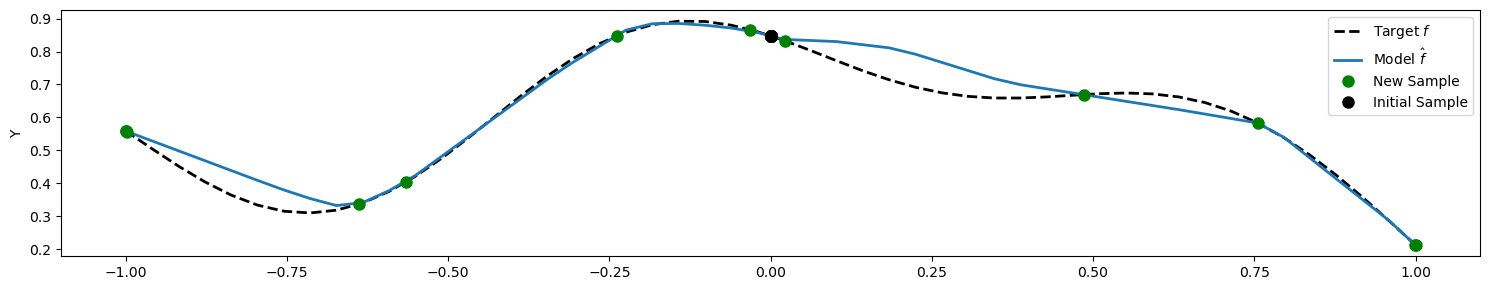

In [33]:
env = envs[43]
state = env.reset()
agent.is_training = False

done=False
while not done:
    action = agent.select_action(state)
    state, reward, done, info = env.step(action)
env.toy_Plot(np.linspace(-1,1,50))

In [39]:
10000*12/3600

33.333333333333336